In [1]:
import numpy as np
from PipeEnv import PipeHeaterSafeEnvGymnasium
from MPCCon import MPCController
from params import *
import matplotlib.pyplot as plt

params["N"] = 30
env = PipeHeaterSafeEnvGymnasium(params, Tinlet=15.0, Tset= 85.0, T_ext=10.0, dt=1.0, t_final=3600)

mpc_dt = 10.0
mpc = MPCController(params, dt=mpc_dt, Hp=80, Q=[0.0, 1e3], R=1e-5, Rd=1.0, T_set=[92.0, 85.0], T_safety=95.0, ramped = True)

obs, _ = env.reset()

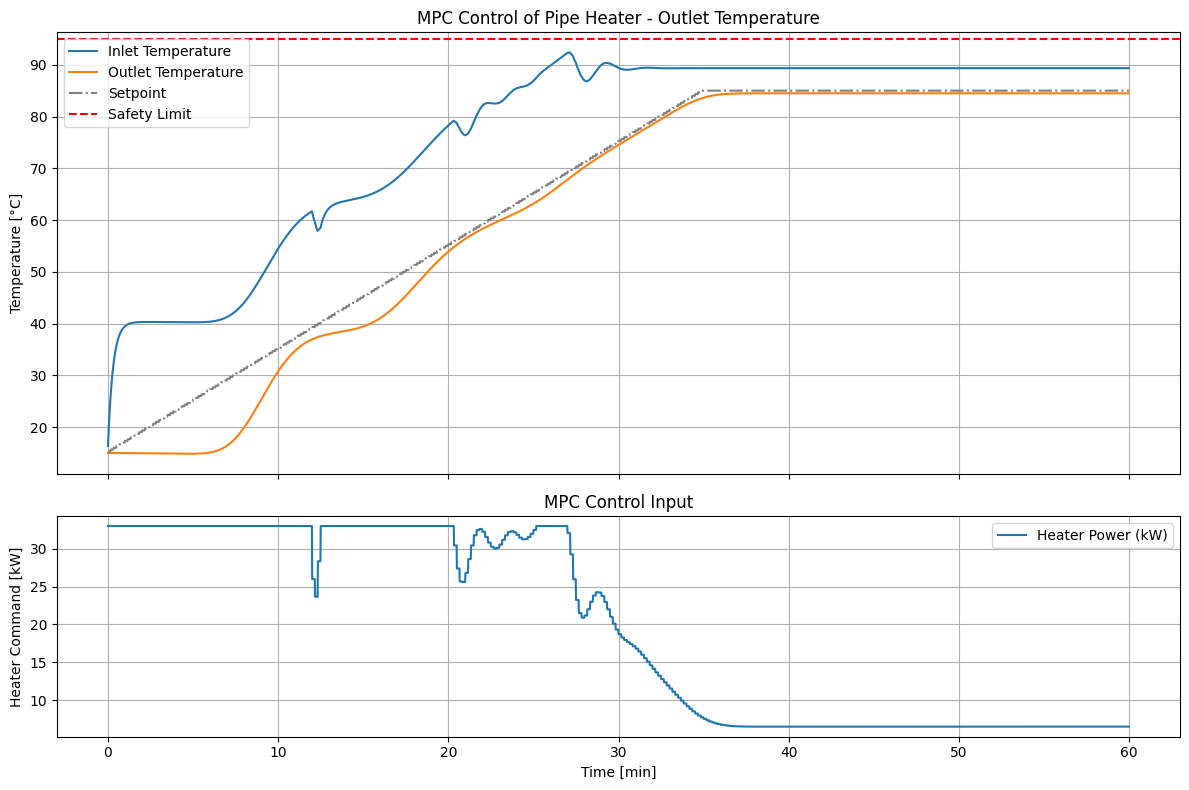

In [2]:
# the env exposes self.T inside; we assume we can access env.T for full state (otherwise use estimator)
x = env.T.copy()
u_prev = 0.0
traj = []
mpc_steps = int(mpc.dt / env.dt)   # number of env steps per MPC update
setpoints = []

for step in range(3600):
    # Update MPC only every mpc_steps
    if step % mpc_steps == 0:
        u_cmd, T_in_sp, T_out_sp = mpc.compute_action(x0=x, u_prev=u_prev)
        u_prev = u_cmd  # store for move suppression, rate constraints, etc.

    # Apply the most recent MPC command
    action = np.array([u_cmd], dtype=np.float32)
    obs, reward, terminated, truncated, info = env.step(action)

    # Save state
    x = env.T.copy()
    traj.append((step, x.copy(), u_cmd, reward))
    setpoints.append((T_in_sp, T_out_sp))

    if terminated:
        break


# now traj contains the run; you can plot Toutlet (x[-1]) over time, etc.
# Unpack trajectory
steps = [t[0]/60 for t in traj]
T_out = [t[1][-1] for t in traj]   # last element of state is outlet temperature
T_in = [t[1][0] for t in traj]   # last element of state is outlet temperature
u_cmds = [t[2] for t in traj]
rewards = [t[3] for t in traj]

T_in_sp = [t[0] for t in setpoints]   # last element of state is outlet temperature
T_out_sp = [t[1] for t in setpoints]   # last element of state is outlet temperature

# Create subplots with different heights
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1]}  # top bigger than bottom
)

# --- Subplot 1: Outlet Temperature ---
ax1.plot(steps, T_in, label="Inlet Temperature")
ax1.plot(steps, T_out, label="Outlet Temperature")
ax1.plot(steps, T_out_sp, color="green", linestyle="-.", label="Setpoint")
ax1.axhline(mpc.T_safety, color="red", linestyle="--", label="Safety Limit")

ax1.set_ylabel("Temperature [°C]")
ax1.set_title("MPC Control of Pipe Heater - Outlet Temperature")
ax1.legend(loc="best")
ax1.grid(True)

# --- Subplot 2: Control Input ---
ax2.plot(steps, u_cmds, label="Heater Power (kW)")
ax2.set_xlabel("Time [min]")
ax2.set_ylabel("Heater Command [kW]")
ax2.set_title("MPC Control Input")
ax2.legend(loc="best")
ax2.grid(True)

plt.tight_layout()

# Save both subplots together
plt.savefig("images/ramp_MPC_results.png", dpi=300)
plt.show()


In [3]:
import pandas as pd

# Convert trajectory data to DataFrame
df = pd.DataFrame({
    "time_min": steps,
    "Tinlet": T_in,
    "Toutlet": T_out,
    "HeaterPower_kW": u_cmds,
    "reward": rewards,
})

# Save to CSV
csv_filename = "results/MPC_run_data_ramp.csv"
df.to_csv(csv_filename, index=False)

print(f"Saved results to {csv_filename}")


Saved results to results/MPC_run_data_ramp.csv


In [12]:
N=3000
x = env.T.copy()
traj_env = []
mpc_dt = 10.0
H = N/mpc_dt

env = PipeHeaterSafeEnvGymnasium(params, Tinlet=15.0, Tset=85.0, T_ext=10.0, dt=1.0, t_final=N)
mpc = MPCController(params, dt=mpc_dt, Hp=70, Q=100.0, R=1e-8, Rd=1.0, T_set=92.0, T_safety=95.0)

for step in range(N):
    u_cmd = 30  # step input
    action = np.array([u_cmd], dtype=np.float32)
    obs, reward, terminated, truncated, info = env.step(action)
    x = env.T.copy()
    traj_env.append((step, x.copy(), u_cmd, reward))
    if terminated:
        break
 
steps_env = [t[0] for t in traj_env]    
T_out = [t[1][-1] for t in traj_env]   # last element of state is outlet temperature
T_in = [t[1][0] for t in traj_env]   # last element of state is outlet temperature
# Define step sequence of length Hp
u_seq = np.ones(mpc.Hp) * 30  

# Initial state (same as env start)
x0 = np.ones(np.shape(mpc.B)) * 15  

# Predict using MPC internal model
X_pred = mpc._predict_trajectory(x0, u_seq)
time_mpc = np.arange(len(X_pred)) * mpc.dt

plt.figure()
plt.plot(steps_env, T_in, label="$T_{inlet}$ full model")
plt.plot(steps_env, T_out, label="$T_{outlet}$ full modele")

plt.plot(time_mpc, X_pred[:,0], '--', label="$T_{inlet}$ MPC prediction")
plt.plot(time_mpc, X_pred[:,-1], '--', label="$T_{outlet}$ MPC prediction")

plt.xlabel("time (s)")
plt.ylabel("Temperature in °C")
plt.legend()
plt.grid()
plt.savefig("images/MPC_vs_full_model.png")

plt.show()



ValueError: Input must be 1- or 2-d.